<a href="https://colab.research.google.com/github/Shazaam91/Hate-Speech-Detection-/blob/main/Sinhala_Hate_Speech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import matplotlib.font_manager as fm
from collections import Counter
from nltk.tokenize import word_tokenize
from textblob import TextBlob

nltk.download('punkt')
plt.rcParams['font.family'] = 'Noto Sans Sinhala'

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('sinhala-hate-speech-dataset.csv', encoding='utf-8')

In [4]:
df.head(10)

,id,comment,label
0,1,`හුදෙකලා´ එකේ `ද´ ඇහෙනවද කාටහරි,0
1,2,18ක පෙනුමක් තියෙන්නේ,0
2,3,2020 එනවා කිව්නාට මෙහෙම එයි කියලා හිතුවේ නෑ පට්ට,0
3,4,25 කැල්ල..හම්මෝ..,0
4,5,25 කෙල්ල අයියලගෙ කාලද කොහෙද ඉන්නෙ,1
5,6,25 ක් වගේ ???ඉතින් වැලලියන්,1
6,7,25 ලුක් එක දැකල ඔලුව සවුත්තු උන තරිදු...,0
7,8,25ක පෙනුමක් කියපු කෑල්ලේ ඉදන් බලන එක නතර කලා,0
8,9,33ක් ගුවන්තොටුපළවල ලෝකයේ හිරවෙලා ඉන්නවා ඩුබායි...,0
9,10,5 දෙනා කිව්වෙ මේ පස්දෙනාද..,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6345 entries, 0 to 6344
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       6345 non-null   int64 
 1   comment  6345 non-null   object
 2   label    6345 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 148.8+ KB


In [6]:
df.describe()

,id,label
count,6345.000000,6345.000000
mean,3173.000000,0.544523
std,1831.788061,0.498053
min,1.000000,0.000000
25%,1587.000000,0.000000
50%,3173.000000,1.000000
75%,4759.000000,1.000000
max,6345.000000,1.000000


In [7]:
df.isnull().sum()

,0
id,0
comment,0
label,0


In [8]:
import re

def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'#\w+', '', text)  # Remove hashtags
    text = re.sub(r'[^A-Za-z\s]', '', text)  # Remove special characters and numbers
    text = text.lower()  # Convert to lowercase
    return text

# Apply cleaning function to all comments
df['cleaned_comment'] = df['comment'].apply(clean_text)

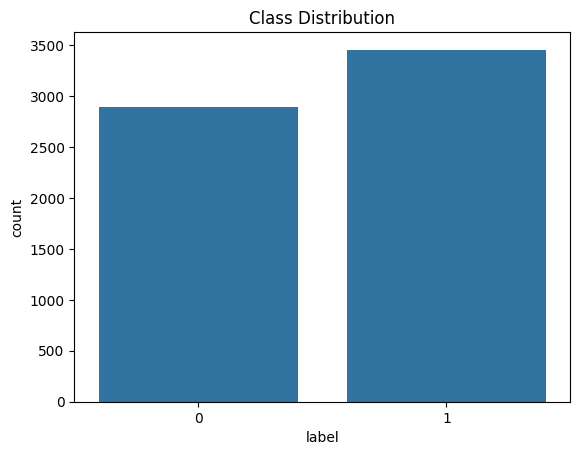

label
1    3455
0    2890
Name: count, dtype: int64


In [9]:
sns.countplot(x='label', data=df)
plt.title('Class Distribution')
plt.show()

# Print the counts of each class
print(df['label'].value_counts())

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-noto-cjk fonts-noto-cjk-extra fonts-noto-color-emoji fonts-noto-core fonts-noto-extra
  fonts-noto-mono fonts-noto-ui-core fonts-noto-ui-extra fonts-noto-unhinted
The following NEW packages will be installed:
  fonts-noto fonts-noto-cjk fonts-noto-cjk-extra fonts-noto-color-emoji fonts-noto-core
  fonts-noto-extra fonts-noto-mono fonts-noto-ui-core fonts-noto-ui-extra fonts-noto-unhinted
0 upgraded, 10 newly installed, 0 to remove and 49 not upgraded.
Need to get 317 MB of archives.
After this operation, 789 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-noto-core all 20201225-1build1 [12.2 MB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-noto all 20201225-1build1 [16.8 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-noto-cjk all 1:2022

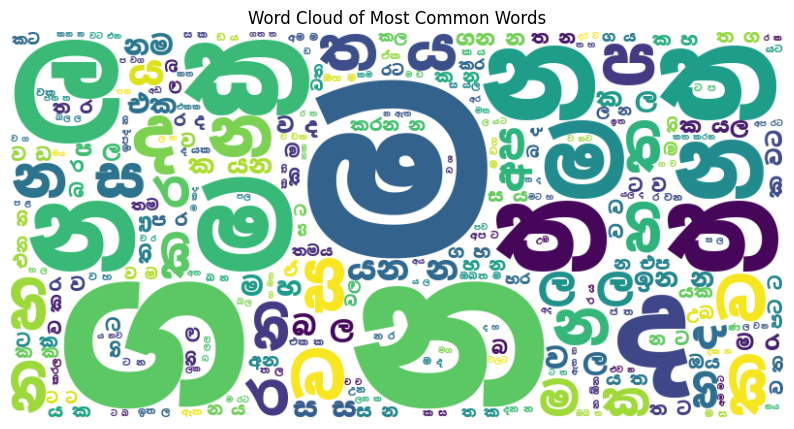

In [10]:
!apt-get install fonts-noto

from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=400, background_color='white', font_path='/content/NotoSansSinhala-Black.ttf').generate(' '.join(df['comment']))

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Common Words')
plt.show()


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 108 (l) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 112 (p) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


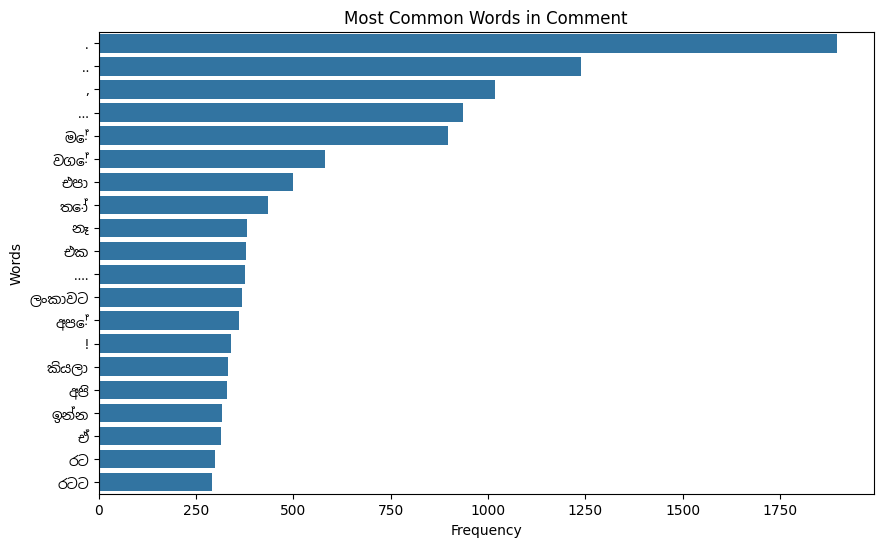

In [11]:
from nltk.tokenize import word_tokenize

# Tokenize the posts
df['tokenized'] = df['comment'].apply(word_tokenize)

# Flatten the list of all words
all_words = [word for tokens in df['tokenized'] for word in tokens]

# Frequency distribution of the most common words
word_freq = Counter(all_words)
common_words = word_freq.most_common(20)

# Set the font properties for Sinhala text
sinhala_prop = fm.FontProperties(fname='/usr/share/fonts/truetype/noto/NotoSansSinhala-Regular.ttf')

# Plotting the most common words
plt.figure(figsize=(10, 6))
sns.barplot(x=[word[1] for word in common_words], y=[word[0] for word in common_words])
plt.title('Most Common Words in Comment')  # Title in English
plt.xlabel('Frequency')  # X-axis label in English
plt.ylabel('Words')  # Y-axis label in English
plt.xticks()  # X-ticks in default font (English)
plt.yticks(fontproperties=sinhala_prop, fontsize=10, rotation=0, ha='right')  # Y-ticks in Sinhala font, aligned to the right

plt.show()

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 108 (l) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 112 (p) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


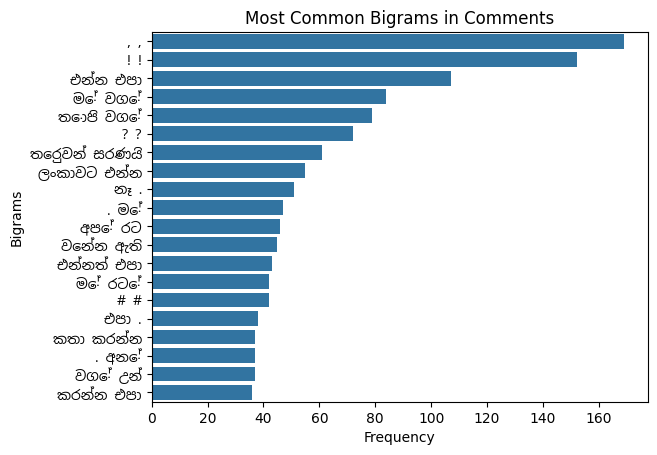

In [12]:
from nltk import ngrams

# Create bigrams
bigrams = list(ngrams(all_words, 2))
bigram_freq = Counter(bigrams).most_common(20)

# Set the font properties for Sinhala text
sinhala_prop = fm.FontProperties(fname='/usr/share/fonts/truetype/noto/NotoSansSinhala-Regular.ttf')

# Plotting the most common bigrams
sns.barplot(x=[bigram[1] for bigram in bigram_freq], y=[' '.join(bigram[0]) for bigram in bigram_freq])

# Adding title and labels
plt.title('Most Common Bigrams in Comments')  # Title in English
plt.xlabel('Frequency')  # X-axis label in English
plt.ylabel('Bigrams')  # Y-axis label in English

# Adjust y-axis ticks for better visibility
plt.yticks(fontproperties=sinhala_prop, fontsize=10, ha='right', rotation=0)  # Y-ticks in Sinhala font, aligned to the right

plt.show()


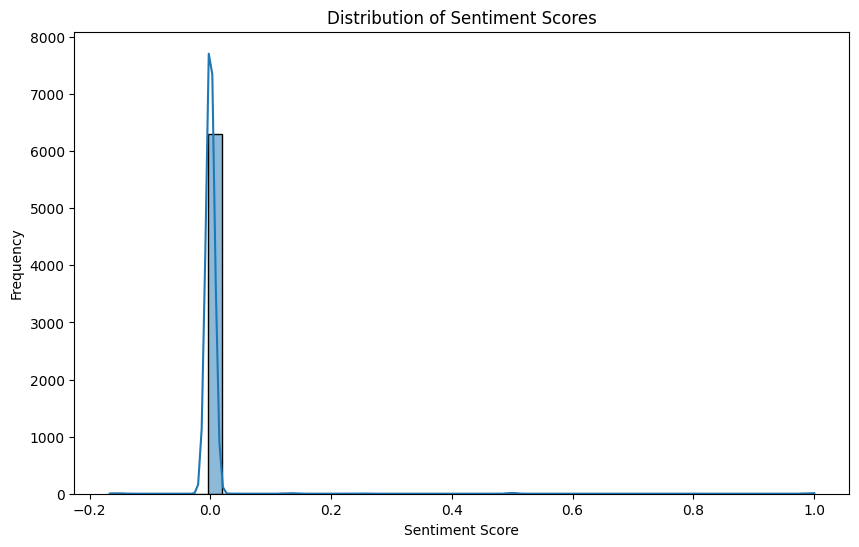

In [13]:
# Calculate sentiment polarity for each post
df['sentiment'] = df['comment'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Plotting the distribution of sentiment scores
plt.figure(figsize=(10, 6))
sns.histplot(df['sentiment'], bins=50, kde=True)
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

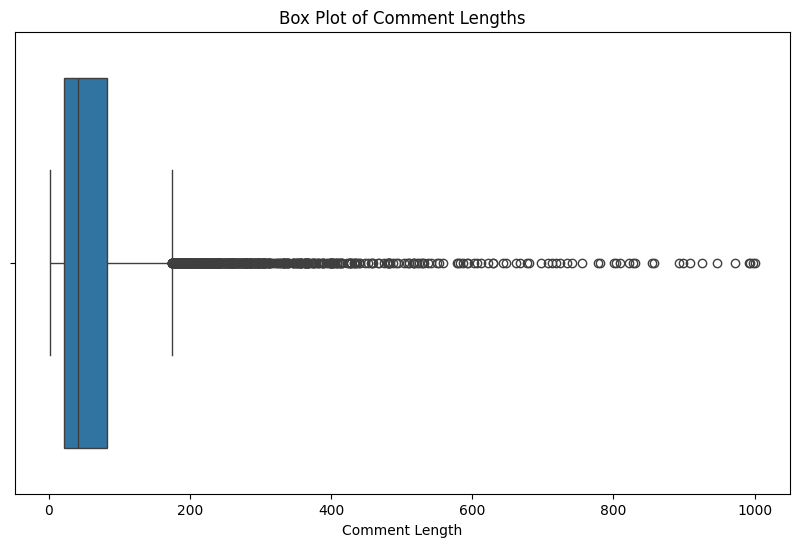

In [14]:
# Calculate the length of each comment
df['comment_length'] = df['comment'].apply(len)

# Plotting a box plot to detect outliers in comment lengths
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['comment_length'])
plt.title('Box Plot of Comment Lengths')
plt.xlabel('Comment Length')
plt.show()


In [15]:
!pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 6.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.5-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.5-py3-none-any.whl (240 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp310-cp310-linux_x86_64.whl size=4246557 sha256=7e24bbd5dc8bf3add6cd549a9dc498bde6ba6c5c1ad49b5bf88d681592fe7a0b
  Stored in directory: /root/.cache/pip/wheels/0d/a2/00/81db54d3e6a8199b829d58e02cec2ddb20ce3e59fad8d3c92a
Successfully built fasttext


In [16]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.si.300.vec.gz
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.si.300.bin.gz

--2024-09-02 19:04:37--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.si.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.18.15, 13.35.18.87, 13.35.18.103, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.35.18.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 481477801 (459M) [binary/octet-stream]
Saving to: ‘cc.si.300.vec.gz’

cc.si.300.vec.gz    100%[===================>] 459.17M   276MB/s    in 1.7s    

2024-09-02 19:04:38 (276 MB/s) - ‘cc.si.300.vec.gz’ saved [481477801/481477801]

--2024-09-02 19:04:38--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.si.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.18.15, 13.35.18.87, 13.35.18.103, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.35.18.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3181346570 (3.0G) [application/octet-stream]
Saving to: ‘cc.si.300.bin

In [17]:
!git clone https://github.com/facebookresearch/fastText.git
!cd fastText
!sudo python setup.py install

Cloning into 'fastText'...
remote: Enumerating objects: 3998, done.
remote: Counting objects: 100% (1026/1026), done.
remote: Compressing objects: 100% (195/195), done.
remote: Total 3998 (delta 890), reused 859 (delta 826), pack-reused 2972 (from 1)
Receiving objects: 100% (3998/3998), 8.30 MiB | 17.89 MiB/s, done.
Resolving deltas: 100% (2528/2528), done.
python3: can't open file '/content/setup.py': [Errno 2] No such file or directory


In [19]:
# Read dataset
dataset = []
with open('sinhala-hate-speech-dataset.csv', encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        label = row['label']
        post = row['comment']
        item = [post]
        if label == '0':
            item.append(0)
        elif label == '1':
            item.append(1)
        else:
            print('ERROR: Unexpected label value')
            continue
        dataset.append(item)

# Extract posts and labels
posts, labels = zip(*dataset)
posts = list(posts)
labels = list(labels)

print(f"Number of records read: {len(dataset)}")
print(f"Length of posts: {len(posts)}")
print(f"Length of labels: {len(labels)}")

Number of records read: 6345
Length of posts: 6345
Length of labels: 6345


In [20]:
# Tokenize posts before resampling
tokenizer = Tokenizer()
tokenizer.fit_on_texts(posts)
sequences = tokenizer.texts_to_sequences(posts)
padded_sequences = pad_sequences(sequences, maxlen=150)

# Check lengths of padded_sequences and labels
print(f"Length of padded_sequences: {len(padded_sequences)}")
print(f"Length of labels: {len(labels)}")

Length of padded_sequences: 6345
Length of labels: 6345


In [21]:
# Apply SMOTE to balance the dataset
sm = SMOTE(random_state=42)
padded_sequences, labels = sm.fit_resample(padded_sequences, labels)

# Check class distribution after SMOTE
print(f"Length of padded_sequences after SMOTE: {len(padded_sequences)}")
print(f"Length of labels after SMOTE: {len(labels)}")

Length of padded_sequences after SMOTE: 6910
Length of labels after SMOTE: 6910


In [22]:
if len(padded_sequences) != len(labels):
    print("Inconsistent lengths detected after SMOTE. Please investigate the issue.")
else:
    print("Lengths are consistent after SMOTE.")

Lengths are consistent after SMOTE.


In [23]:
# Convert posts and labels to numpy arrays for consistency
posts = np.array(posts)
labels = np.array(labels)

In [24]:
# Trim the labels to match the length of posts
labels = labels[:len(posts)]

In [25]:
# Check the lengths after trimming
print(f"Length of posts after trimming: {len(posts)}")
print(f"Length of labels after trimming: {len(labels)}")

Length of posts after trimming: 6345
Length of labels after trimming: 6345


In [27]:
# Now split the text data into training and testing sets
X_train_text, X_test_text, y_train, y_test = train_test_split(posts, labels, test_size=0.1, random_state=42)

print(f"Training set size: {len(X_train_text)}, Test set size: {len(X_test_text)}")

Training set size: 5710, Test set size: 635


In [28]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define parameters for tokenization and padding
vocab_size = 10000
max_length = 120
trunc_type = 'post'
oov_tok = ""

# Initialize the tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

# Fit the tokenizer on the training text data
tokenizer.fit_on_texts(X_train_text)  # Ensure X_train_text is a list of texts

# Convert text data to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train_text)
X_test_seq = tokenizer.texts_to_sequences(X_test_text)  # Ensure X_test_text is a list of texts

# Pad sequences to ensure consistent input length
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, truncating=trunc_type)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, truncating=trunc_type)

# Output shapes of the padded sequences
print(f"Shape of padded training data: {X_train_padded.shape}")
print(f"Shape of padded testing data: {X_test_padded.shape}")


Shape of padded training data: (5710, 120)
Shape of padded testing data: (635, 120)


In [29]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.si.300.bin.gz
!gzip -d cc.si.300.bin.gz

--2024-09-02 19:30:39--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.si.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.18.87, 13.35.18.102, 13.35.18.103, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.35.18.87|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3181346570 (3.0G) [application/octet-stream]
Saving to: ‘cc.si.300.bin.gz.1’

cc.si.300.bin.gz.1  100%[===================>]   2.96G   206MB/s    in 14s     

2024-09-02 19:30:54 (212 MB/s) - ‘cc.si.300.bin.gz.1’ saved [3181346570/3181346570]



In [30]:
import fasttext

# Load FastText model
ft = fasttext.load_model('cc.si.300.bin')

# Define the embedding dimension
embedding_dim = 300  # Ensure this matches the FastText vector size

# Initialize the embedding matrix
embeddings_matrix = np.zeros((vocab_size + 1, embedding_dim))

# Populate the embedding matrix
for word, i in tokenizer.word_index.items():
    if i >= vocab_size:  # Skip words beyond vocab_size
        continue
    embedding_vector = ft.get_word_vector(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

In [31]:
from tensorflow.keras import layers, models, regularizers

model = models.Sequential([
    layers.Embedding(input_dim=vocab_size + 1, output_dim=embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    layers.Bidirectional(layers.LSTM(32, dropout=0.5)),
    layers.Dense(24, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dense(1, activation='sigmoid')
])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │       3,000,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,000,300 (11.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,000,300 (11.45 MB)

In [32]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss="binary_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [33]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

In [35]:
num_epochs = 100

# Fit the model with training data and include the callbacks for early stopping and checkpointing
history = model.fit(
    X_train_padded,  # Use the padded training data
    y_train,         # Use the training labels
    validation_split=0.1,  # Use 10% of the training data for validation
    epochs=num_epochs,
    batch_size=32,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.7132 - loss: 0.6142 - val_accuracy: 0.8109 - val_loss: 0.4267
Epoch 2/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.8379 - loss: 0.3839 - val_accuracy: 0.8249 - val_loss: 0.3961
Epoch 3/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.8460 - loss: 0.3595 - val_accuracy: 0.8546 - val_loss: 0.3435
Epoch 4/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8476 - loss: 0.3411 - val_accuracy: 0.8476 - val_loss: 0.3952
Epoch 5/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8636 - loss: 0.3196 - val_accuracy: 0.8424 - val_loss: 0.3623
Epoch 6/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8671 - loss: 0.3029 - val_accuracy: 0.8406 - val_loss: 0.3683
Epoch 7/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8764 - loss: 0.2899 - val_accuracy: 0.8424 - val_loss: 0.3910
Epoch 8/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8850 - loss: 0.2648 -

In [36]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss="binary_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [37]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

In [38]:
# Fit the model with training data and include the callbacks for early stopping and checkpointing
history = model.fit(
    X_train_padded,  # Use the padded training data
    y_train,         # Use the training labels
    validation_split=0.1,  # Use 10% of the training data for validation
    epochs=num_epochs,
    batch_size=32,
    callbacks=[early_stopping, checkpoint]
)



Epoch 1/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.8560 - loss: 0.3335 - val_accuracy: 0.8301 - val_loss: 0.3527
Epoch 2/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.8632 - loss: 0.3185 - val_accuracy: 0.8354 - val_loss: 0.3661
Epoch 3/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8610 - loss: 0.3055 - val_accuracy: 0.8476 - val_loss: 0.3545
Epoch 4/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.8560 - loss: 0.3229 - val_accuracy: 0.8704 - val_loss: 0.3277
Epoch 5/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8701 - loss: 0.2910 - val_accuracy: 0.8144 - val_loss: 0.3672
Epoch 6/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8792 - loss: 0.2927 - val_accuracy: 0.8511 - val_loss: 0.3261
Epoch 7/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8704 - loss: 0.3023 - val_accuracy: 0.8424 - val_loss: 0.3481
Epoch 8/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.8869 - loss: 0.2814 - 

In [39]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test_padded, y_test)
print(f"Test Accuracy: {accuracy}")
print(f"Test Loss: {loss}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8704 - loss: 0.3298
Test Accuracy: 0.869291365146637
Test Loss: 0.33087673783302307


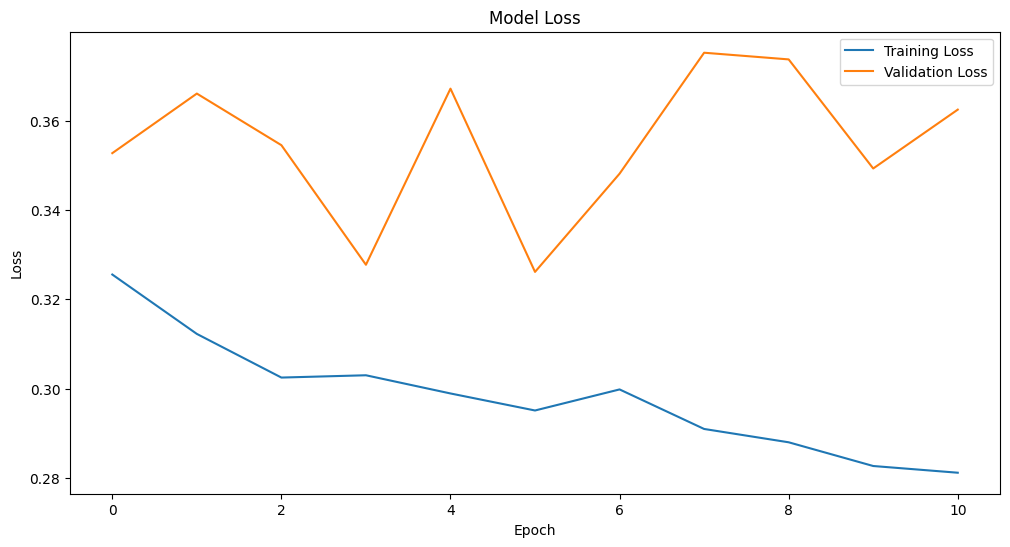

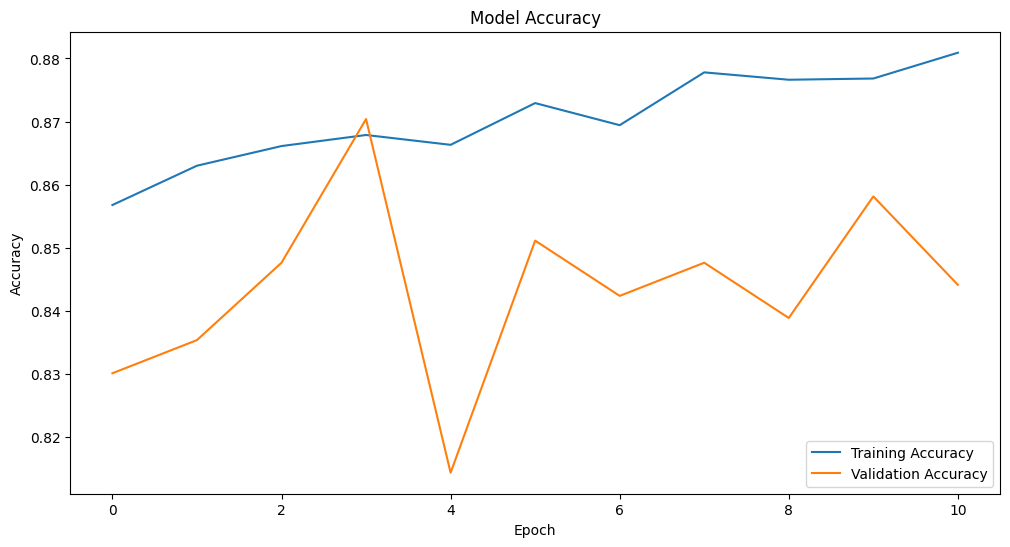

In [40]:
# Plotting training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# Plotting training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [41]:
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test, batch_size=32)
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Loss: {test_loss}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8351 - loss: 0.3692
Test Accuracy: 0.8440945148468018
Test Loss: 0.35416117310523987


In [42]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict on the test set
predictions = model.predict(X_test_padded)
predictions = [1 if p > 0.5 else 0 for p in predictions]

# Print classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test, predictions))
print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       300
           1       0.89      0.83      0.86       335

    accuracy                           0.85       635
   macro avg       0.85      0.86      0.85       635
weighted avg       0.86      0.85      0.85       635

Confusion Matrix:
[[265  35]
 [ 58 277]]


In [43]:
!pip install keras-tuner -q

from keras_tuner import HyperModel
from keras_tuner.tuners import RandomSearch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 10.3 MB/s eta 0:00:00


In [46]:
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Model
from keras_tuner import HyperModel

class HateSpeechDetectionHyperModel(HyperModel):
    def build(self, hp):
        # Hyperparameters to tune
        lstm_units = hp.Int('lstm_units', min_value=16, max_value=64, step=16)
        dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
        dense_units = hp.Int('dense_units', min_value=16, max_value=64, step=16)
        l2_reg = hp.Choice('l2_reg', values=[0.01, 0.001, 0.0001])

        # Define the model
        model = models.Sequential([
            layers.Embedding(input_dim=vocab_size + 1, output_dim=embedding_dim,
                             weights=[embeddings_matrix], trainable=False),
            layers.Bidirectional(layers.LSTM(lstm_units, dropout=dropout_rate)),
            layers.Dense(dense_units, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)),
            layers.Dense(1, activation='sigmoid')
        ])

        # Compile the model
        model.compile(
            optimizer=tf.keras.optimizers.Adam(
                hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        return model


In [47]:
hypermodel = HateSpeechDetectionHyperModel()

# Define the tuner
tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=10,  # Number of different hyperparameter combinations to try
    executions_per_trial=2,  # Number of models to train per combination
    directory='my_dir',
    project_name='hate_speech_detection'
)

In [48]:
tuner.search(X_train_padded, y_train,
             validation_split=0.1,
             epochs=num_epochs,
             batch_size=32,
             callbacks=[early_stopping])

# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

Trial 10 Complete [00h 00m 42s]
val_accuracy: 0.8476357161998749

Best val_accuracy So Far: 0.8616462349891663
Total elapsed time: 00h 06m 23s


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [49]:
loss, accuracy = best_model.evaluate(X_test_padded, y_test)
print(f"Best Model Test Accuracy: {accuracy}")
print(f"Best Model Test Loss: {loss}")

# Predict on the test set and print classification report
predictions = best_model.predict(X_test_padded)
predictions = [1 if p > 0.5 else 0 for p in predictions]

print("Classification Report:")
print(classification_report(y_test, predictions))
print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8045 - loss: 0.4226
Best Model Test Accuracy: 0.8299212455749512
Best Model Test Loss: 0.39805978536605835
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.83      0.85       300
           1       0.86      0.88      0.87       335

    accuracy                           0.86       635
   macro avg       0.86      0.86      0.86       635
weighted avg       0.86      0.86      0.86       635

Confusion Matrix:
[[250  50]
 [ 39 296]]


In [62]:
# Saving the model Keras format
model.save('hate_speech_model.keras')

In [63]:
from tensorflow import keras

# Loading the model
loaded_model = keras.models.load_model('hate_speech_model.keras')

In [64]:
def predict_hate_speech(text, model, tokenizer, max_length, threshold=0.5):
    # Preprocess the input text
    sequences = tokenizer.texts_to_sequences([text])
    padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

    # Make a prediction
    prediction = model.predict(padded_sequences)

    # Determine the label with the adjusted threshold
    label = 'Hate Speech' if prediction[0] > threshold else 'Non-Hate Speech'
    confidence = float(prediction[0])

    return label, confidence

In [81]:
# Example Sinhala text
text = "Unp කියන්නෙ කන්නම ඉපදිච්ච ජාතියක් වැඩිය ඔානෙ නෑ.. මුන්ගෙ කාලෙ හිටපු පොලිස් මාධ්‍ය ප්‍රකාශක හිටියනම් මෙලහටත් හත්පොලේ ගූ ගාගෙන"

# Test the loaded model
label, score = predict_hate_speech(text, loaded_model, tokenizer, max_length=120)  # Adjust max_length as needed
print(f"Prediction: {label} (Confidence: {score:.2f})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction: Hate Speech (Confidence: 0.81)


<ipython-input-64-8e07a3d2a407>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  confidence = float(prediction[0])
